**Aplicação de técnicas de classificação de texto na arquitetura de Chatbots hierárquicos**

**Mestrado Profissional em Computação Aplicada - PPCA - Universidade de Brasília**

**Disciplina**: Mineração de Dados

**Orientador**: Prof. Dr. Marcelo Ladeira <mladeira@unb.br>

**Alunos**: 
 - José Ronaldo Agra De Souza Filho <jose.agra@aluno.unb.br>
 - Bruno Gomes Resende <bruno.resende@aluno.unb.br>
 - Célio Castro Wermelinger <celio.wermelinger@aluno.unb.br> 

**Palavras-Chave:**

Chatbot; Text Classification; Machine Learning; Text Mining; NLP;

In [1]:
# Install packages
# Note: use Python 3.8 env
#!pip install --pre pycaret

## Importação das bibliotecas necessárias a este notebook.

In [2]:
# Import packages
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pycaret.classification import *

# download das stopwords para o idioma português
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Montagem dos datasets a serem utilizados no experimento

Cada categoria possui um arquivo contendo o texto que serve se exemplo de treinamento e a categoria de cada um desses textos.

Primeiro é montado um único dataset, contendo todos os exemplos das 3 classes, e as referidas categorias.

Após isso, este dataset é clonado 3 vezes, sendo um para cada classe. Nestes novos datasets, a categorizaçõ passa a ser binária. Ou seja, em vez de ter a informação das 3 classes, ele tem a informação se os exemplos de treinamento são ou não de uma referida classe.

Assim, cria-se os seguintes datasets:
* df_treino_covid: contém todos os exemplos de treinamento. Para os que representam a classe "covid", a coluna "category" é configurada com 1, caso contrário com 0.
* df_treino_seloturismo: contém todos os exemplos de treinamento. Para os que representam a classe "seloturismo", a coluna "category" é configurada com 1, caso contrário com 0.
* df_treino_tuberculose: contém todos os exemplos de treinamento. Para os que representam a classe "tuberculose", a coluna "category" é configurada com 1, caso contrário com 0.

In [3]:
# Montagem do dataset
df_covid = pd.read_csv('data/exemplos-treinamento-covid.csv', delimiter=';')
df_seloturismo = pd.read_csv('data/exemplos-treinamento-seloturismo.csv', delimiter=';')
df_tuberculose = pd.read_csv('data/exemplos-treinamento-tuberculose.csv', delimiter=';')
df_teste = pd.read_csv('data/dados-testes-experimentos.csv', delimiter=';')

df_all = pd.concat([df_covid, df_seloturismo, df_tuberculose, df_teste], axis=0)
df_all.reset_index(drop=True, inplace=True)
df_all['category'] = df_all.reset_index().category.map({'covid':0, 'seloturismo':0, 'tuberculose':1})

## Representação dos textos em vetores

Realiza a representação de texto, fazendo uso do TF-IDF e realizando algumas tarefas de tratamento dos dados.

Ao realizar a vetorização dos textos, são removidas as stopwords e também os acentos das palavras.

Deciciu-se por não realizar as tarefas de "lemmatization" nem de "stemming", porque no caso deste experimento a simplificação de palavras em radicais poderia prejudicar o desempenho na identificação das classes.

In [4]:
# recupera as stopwords do idioma português
stop_words = stopwords.words('portuguese')

# vetorização das palavras
tv = TfidfVectorizer(lowercase=True, stop_words=stop_words, strip_accents='unicode', token_pattern="[A-Za-z]+")

tf_idf_tuberculose = tv.fit_transform(df_all['input'])

# vetorização para o dataframe referente à categoria COVID
df_dados_vetorizados = pd.DataFrame(tf_idf_tuberculose.toarray(), columns=tv.get_feature_names())
df_dados_vetorizados['target_cat'] = df_all.reset_index().category

dados_treino_validacao = df_dados_vetorizados.sample(frac=0.8, random_state=786).reset_index(drop=True)
dados_teste = df_dados_vetorizados.drop(dados_treino_validacao.index).reset_index(drop=True)

print('Dados para modelagem (treino/validação): ' + str(dados_treino_validacao.shape))
print('Dados para testes: ' + str(dados_teste.shape))

dados_treino_validacao


Dados para modelagem (treino/validação): (959, 1497)
Dados para testes: (240, 1497)


,abdomen,abracar,abrace,abraco,acessibilidade,acesso,acho,acionar,acometer,acometidos,acompanhados,acompanhamento,acontece,acontecera,acordo,acougue,acrescido,acrescimo,acrescimos,adequada,aderi,aderir,aderiram,aderiu,adesao,adesoes,adianta,adiantou,adicionais,adicional,adocao,adoecem,adoecimento,adota,adotadas,adotado,adotando,adotar,adotaram,adotarem,adotou,adultos,adverso,aerossois,aferir,afeta,afetadas,afetar,afetem,africa,agencia,agir,aglomeracoes,agora,agressiva,agressivas,agua,ainda,ajuda,ajudara,albergaria,albergues,alcool,alem,alguem,algum,alguma,alimentar,alimentos,alojam,alojar,ambientais,ambiental,ambiente,ambientes,animais,ano,anos,antes,anticorpo,antiga,antigo,anvisa,aparece,apareceu,aparelho,apenas,aperto,apesar,aplicabilidade,aplicadas,aplicam,aplicando,aplicaveis,apoio,apontem,apos,apresenta,apresente,aprovacao,aprovadas,aprovado,aproximadamente,aptos,ar,arca,area,areas,arma,artesanato,ase,assim,assintomatico,associou,astrazeneca,asua,ate,atencao,atende,atender,atendimento,atestado,atinge,atitude,ativa,ativacao,ativado,ativara,atividade,atividades,ativo,atracoes,atrativos,atraves,atua,atualizacao,atualizacoes,atualizado,atualizar,atualizarei,atuando,auditorias,aumenta,aumentam,aumentar,aumentarao,aumento,auto,autorizacao,aval,avalia,avaliacao,avaliada,bacilo,bacilos,baciloscopia,bacteria,bacteriana,bacterias,bacteriologico,baixa,baixar,bancos,banheiro,bares,base,bcg,bebedouro,beber,bebida,bebidas,beijo,beijos,bem,beneficios,bexiga,biosseguranca,boas,boca,br,brasil,brasileiro,bubcar,buscar,busco,butantan,cabelo,cada,cadastrado,cadastrados,cadastramento,cadastrar,cadastro,cadastrotur,cadastrur,cadastur,cadtrur,cadtur,calendario,calmette,caminhada,cancelar,capacidade,capacitados,carne,carro,cartao,casa,caseiro,caso,casos,catarro,causa,causada,causam,causando,cd,cedula,central,cerca,cerebral,cerebro,certeza,certificacao,cgu,chama,chance,chegar,cheio,cheiro,china,chineses,cidadao,circulacao,circulando,circular,clientes,clinico,clique,cliquei,cobertura,cobrada,cobrado,cobrar,cobrir,code,coemcou,coisa,coisas,colaboradores,...,sair,sairam,saiu,sanguinea,sanitaria,sanitarias,sanitario,sao,sarar,sars,saude,seca,secrecoes,sedex,segmento,segue,segui,seguido,seguindo,seguintes,seguir,segunda,segura,seguranca,seguras,seguro,seguros,sei,seis,sel,selecionei,selo,selos,semanas,sempre,sendo,sensibilidade,sensivel,sentido,sentindo,sentir,sentira,sentirao,sequenciamento,sera,serao,serve,servico,servicos,setor,setores,setorias,severa,sido,significa,sim,similares,sinalizacao,sinalizacoes,sinovac,sintam,sintoma,sintomas,sistema,sistematizadas,site,situacao,so,sobre,sobrevive,sociais,sofrerao,sol,solar,solicitacao,solicitar,status,subdividido,submetidos,sucesso,sugestiva,sujos,sul,superficies,supermercado,surgir,surjam,sus,suspeitos,suspendi,suspensa,suspensao,suspensas,sustentabilidade,sustentam,tabaco,tabela,talheres,tambem,tanto,tapete,taxa,taxas,tb,tbsnc,tecido,tecidos,tecnico,tempo,tendencia,ter,tera,terao,terbeculose,teste,testes,tiberculose,tipo,tipos,tira,tirar,toalha,tocando,tocar,toda,todas,todo,todos,tomado,tomar,tomei,torax,tornar,tornara,tosse,tossir,trabalho,tradicional,transmissao,transmissivel,transmite,transmitida,transmitido,transmitidos,transmitir,transportadoras,transporte,transversais,trara,trasmitida,tratamento,tratar,traves,traz,treinamento,tres,trm,troca,tuberculose,tuberculosis,tuberculoso,tudo,turismo,turista,turistas,turistica,turisticas,turistico,turisticos,tussa,uber,umida,unhas,uniao,unico,unidade,unido,urinaria,urinario,usa,usada,usar,uso,usuario,usuarios,usufluir,utensilhos,utilizacao,utilizados,utilizando,utilizar,vacina,vacinacao,vacinada,vacinadas,vacinado,vacinal,vacinar,vacinas,vai,validacao,validade,validados,valor,valorizacao,vantagem,vantagens,vantajoso,vao,variacao,variante,variantes,varias,varios,varrer,vc,veiculos,veio,vejo,vem,vendi,ver,verduras,verificar,verificara,verifico,via,viagem,viajar,vias,vida,vigilancia,vindo,vir,virilha,virus,visita,visitar,visivel,vistoria,vistoriar,vistorias,vi

## Criação dos classificadores binários

São criados 3 classificadores binários, cada um especializado em identificar uma das categorias existentes: covid, selo turismo e tuberculose.

Para cada classificador, a configuração utilizada será:
* Dados a classificar (data): dados relacionados à categoria COVID;
* Coluna que representa a classe (target): a coluna 'target_cat' que informa se o texto é da classe covid (1) ou não (0).
* Semente para possibilitar a reprodutibilidade (session_id): 20221
* Proporção do dataset que será usado para treinamento e validação (train_size): 70%
* Quantidade de dobras (folds) que será utilizada na validação cruzada (fold): 10 (por padrão a estratégia utilizada é a 'stratified kfold').
* Controle da entrada de confirmação de tipos de dados quando o setup é executado (silent): True (devido ao modo de execução automatizado).

## Classificador binário para a classe COVID

In [5]:
config_tuberculose = setup(data=dados_treino_validacao, target='target_cat', session_id=20221, fold=10,
                           train_size = 0.7, test_data=dados_teste, silent=True, fix_imbalance=True)

,Description,Value
0,session_id,20221
1,Target,target_cat
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(959, 1497)"
5,Missing Values,False
6,Numeric Features,754
7,Categorical Features,742
8,Ordinal Features,False
9,High Cardinality Features,False


## Comparação entre os modelos disponíveis na biblioteca

Essa função treina todos os modelos disponíveis da biblioteca, e os pontua usando validação cruzada configurada no setup estratificada para avaliação de métricas.

A saída imprime uma grade de pontuação que mostra as métricas: acurácia média, AUC, recall, precisão e F1 de todos os modelos disponíveis na biblioteca de modelos.


In [6]:
compare_models(probability_threshold=0.75)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9906,0.9968,0.9739,0.9868,0.9801,0.9740,0.9742,0.2620
rf,Random Forest Classifier,0.9885,0.9966,0.9609,0.9909,0.9752,0.9678,0.9683,0.2120
ridge,Ridge Classifier,0.9875,0.0000,0.9648,0.9828,0.9729,0.9648,0.9655,0.1220
dt,Decision Tree Classifier,0.9864,0.9835,0.9561,0.9861,0.9705,0.9617,0.9622,0.0910
xgboost,Extreme Gradient Boosting,0.9844,0.9882,0.9342,1.0000,0.9650,0.9550,0.9567,0.9970
gbc,Gradient Boosting Classifier,0.9833,0.9860,0.9338,0.9955,0.9626,0.9520,0.9535,0.4560
ada,Ada Boost Classifier,0.9823,0.9898,0.9296,0.9958,0.9606,0.9493,0.9510,0.2240
catboost,CatBoost Classifier,0.9823,0.9937,0.9294,0.9955,0.9603,0.9490,0.9507,5.8050
lr,Logistic Regression,0.9812,0.9993,0.9209,1.0000,0.9574,0.9455,0.9479,0.6310
lightgbm,Light Gradient Boosting Machine,0.9760,0.9876,0.9247,0.9730,0.9474,0.9319,0.9331,0.1100


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=20221, verbose=0,
                     warm_start=False)

## Criando os modelos melhor pontuados na compare_models

In [7]:
# cria o modelo
modelo = create_model('et',probability_threshold=0.75)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9896,1.0000,1.0000,0.9565,0.9778,0.9710,0.9714
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9896,1.0000,0.9565,1.0000,0.9778,0.9710,0.9714
4,0.9896,0.9729,0.9565,1.0000,0.9778,0.9710,0.9714
5,0.9792,0.9994,0.9565,0.9565,0.9565,0.9428,0.9428
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9896,0.9982,0.9565,1.0000,0.9778,0.9710,0.9714
8,0.9688,0.9979,0.9130,0.9545,0.9333,0.9129,0.9133


In [8]:
# realiza o ensemble dos modelos e seleciona o melhor
melhor_modelo_bagging = ensemble_model(modelo, choose_better=True,
                                       return_train_score=True,
                                       probability_threshold=0.75)

In [9]:
# Imprimindo melhor modelo
print(melhor_modelo_bagging)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=20221, verbose=0,
                     warm_start=False)


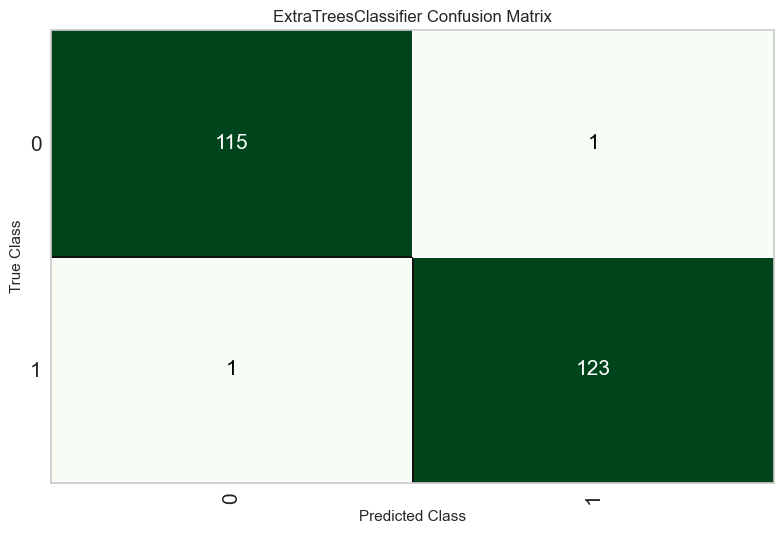

In [10]:
plot_model(melhor_modelo_bagging, plot = 'confusion_matrix')

In [ ]:
plot_model(melhor_modelo_bagging, plot = 'error')

## Predição do modelo treinado

Antes de finalizar o modelo, realiza-se uma verificação final prevendo o conjunto de teste/hold-out e revisando as métricas de avaliação. Esta verificação é realizada com os 30% dos dados separados para isto no início deste notebook.

Perceba abaixo que não houve grande variação entre os resultados do teste/hold-out e do treinamento, inclusive as métricas do teste se apresentam melhores, isso indica que não ocorreu o overfitting.

In [11]:
predict_model(melhor_modelo_bagging, probability_threshold=0.75)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9917,0.9994,0.9919,0.9919,0.9919,0.9833,0.9833


,abdomen,acessibilidade,acesso,acho,acometidos,acompanhamento,acontece,aderir,aderiram,aderiu,...,vantajoso_0.8132408261299133,varias_0.0,verificara_0.43883538246154785,vindo_0.0,vistorias_0.7109053134918213,vivem_0.5207983255386353,vulneravel_0.0,target_cat,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1.00
236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1.00
237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0.80
238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1.00


## Finalização do modelo

A finalização do modelo é a última etapa do experimento. A função finalize_model() ajusta o modelo ao conjunto de dados completo, incluindo a amostra de teste/hold-out (30% neste caso). O objetivo dessa função é treinar o modelo no conjunto de dados completo antes de ser implantado na produção.

In [12]:
modelo_final = finalize_model(melhor_modelo_bagging)
predicoes = predict_model(modelo_final, probability_threshold=0.75)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9917,0.9994,0.9919,0.9919,0.9919,0.9833,0.9833


In [13]:
predicoes.head(200)

,abdomen,acessibilidade,acesso,acho,acometidos,acompanhamento,acontece,aderir,aderiram,aderiu,...,vantajoso_0.8132408261299133,varias_0.0,verificara_0.43883538246154785,vindo_0.0,vistorias_0.7109053134918213,vivem_0.5207983255386353,vulneravel_0.0,target_cat,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,1.000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1.000
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1.000
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0.898
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1.000


## Salvando o modelo final

Agora terminamos o experimento finalizando o modelo que agora está armazenado na variável 'modelo_final'.

Nosso modelo final pode ser descrito como:

Também usamos o modelo armazenado em final_rf para prever data_unseen. Isso nos leva ao final de nosso experimento, mas uma pergunta ainda deve ser feita: o que acontece quando você tem mais dados novos para prever? Você tem que passar por todo o experimento novamente? A resposta é não, a função embutida do PyCaret save_model() permite que você salve o modelo junto com todo o pipeline de transformação para uso posterior.

In [ ]:
save_model(modelo_final,'models/20220914-modelo-final-tuberculose-decision-tree')